# Fundamentals of Machine Learning - Exercise 4
* Goal of the excercise is to learn how to use **K-means** implementation in the Scikit-learn library to perform clustering and subsequent cluster analysis on a Titanic dataset.

## üîé Let's discuss the clustering topic a bit first
* What task do clustering algorithms solve?
* Do you know any examples of such algorithms?
* What are the limitation of clustering algorithms?

## üîé What is the **most difficult** of the clustering tasks?

![meme01](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_04_meme_01.jpg?raw=true)

## üí° But don't worry we will deal with the topic in several lectures üòä

## Import the libraries
*üîé  What is the **sklearn** library?

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

# We will work with the famous Titanic dataset ‚õµ

## Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fianc√©s were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

* Dataset is available at https://www.kaggle.com/competitions/titanic'

## Load dataset
* https://raw.githubusercontent.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/master/datasets/titanic.csv

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/master/datasets/titanic.csv', index_col=0)
df.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

## How many missing values do we have in the data?

In [3]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64

## We are going to cluster the passangers into defined number of groups
* It is clear that it is mandatory to select only a relevant subset of features
    * Name the new DF as *df_clustering*
* üîé Is *Name* or *Ticket* relevant?
    * 'Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'

1. Select the features
2. Drop *NaN* values
3. Change type of *Sex* and *Embarked* to string
    * **astype()** function

In [4]:
df_clustering = df[['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
df_clustering = df_clustering.dropna()
df_clustering['Sex'] = df_clustering['Sex'].astype(str)
df_clustering['Embarked'] = df_clustering['Embarked'].astype(str)
df_clustering.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                                
1                   0       3    male  22.0      1      0   7.2500        S
2                   1       1  female  38.0      1      0  71.2833        C
3                   1       3  female  26.0      0      0   7.9250        S
4                   1       1  female  35.0      1      0  53.1000        S
5                   0       3    male  35.0      0      0   8.0500        S

## Check *shape* and *dtypes*

In [5]:
df_clustering.shape

(712, 8)

In [6]:
df_clustering.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

# Print the dataset

## üîé Does everything seem OK?

In [7]:
df_clustering

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                                
1                   0       3    male  22.0      1      0   7.2500        S
2                   1       1  female  38.0      1      0  71.2833        C
3                   1       3  female  26.0      0      0   7.9250        S
4                   1       1  female  35.0      1      0  53.1000        S
5                   0       3    male  35.0      0      0   8.0500        S
...               ...     ...     ...   ...    ...    ...      ...      ...
886                 0       3  female  39.0      0      5  29.1250        Q
887                 0       2    male  27.0      0      0  13.0000        S
888                 1       1  female  19.0      0      0  30.0000        S
890                 1       1    male  26.0      0      0  30.0000        C
891                 0       3    male  32.0      0      0   7.7500        Q

[712 rows x 8 columns]

# We can see that not all features are numerical
* üîé Is it a problem?
    * Why?
* üîé How to deal with it?

## We have two basic encoding options
* Ordinal encoding vs. One-hot encoding
* What is the difference?
    * Is thete difference in dimensionality change? Why it can be an issue?
    * When is ordinal encoding appropriate?
    * Can you omit the pre-requirements of ordinal encoding sometimes?

## Lets encode categorical features
* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
* https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing



In [8]:
enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])[:20]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [9]:
enc.categories_

[array(['female', 'male'], dtype=object)]

## üí° You may ask why do we use the `dataframe[['feature_name']]` notation with double `[[` and `]]` brackets
* **Single brackets** pair around one variable name means that you want to select just the `pandas.Series` object

In [10]:
df_clustering['Sex']

PassengerId
1        male
2      female
3      female
4      female
5        male
        ...  
886    female
887      male
888    female
890      male
891      male
Name: Sex, Length: 712, dtype: object

* **Double brackets** pair around one variable name created an output in the `pandas.DataFrame` format

In [11]:
df_clustering[['Sex']]

Sex
PassengerId        
1              male
2            female
3            female
4            female
5              male
...             ...
886          female
887            male
888          female
890            male
891            male

[712 rows x 1 columns]

## There is OneHotEncoder as well, however I recommend using `pd.get_dummies` method instead

In [12]:
pd.get_dummies(df_clustering['Embarked']).head()

C      Q      S
PassengerId                     
1            False  False   True
2             True  False  False
3            False  False   True
4            False  False   True
5            False  False   True

## Let's finish the encoding part and create a new dataframe with encoded data
1. Create empty *df_encoded* dataframe with index using *df_clustering.index*
2. Create *Sex* variable with ordinal encoded data
3. Use `join` method for added one-hot encoded *Embarked* feature

In [13]:
df_encoded = pd.DataFrame(index=df_clustering.index)



In [14]:
df_encoded['Sex'] =sklearn.preprocessing.OrdinalEncoder().fit_transform(df_clustering[['Sex']])

In [15]:
df_encoded = df_encoded.join(pd.get_dummies(df_clustering['Embarked']))
df_encoded.head()

Sex      C      Q      S
PassengerId                          
1            1.0  False  False   True
2            0.0   True  False  False
3            0.0  False  False   True
4            0.0  False  False   True
5            1.0  False  False   True

# It is important to select the appropriate scaling method of the number features
* There are many ways how to do this - **MinMax, StandardScaler, PowerTransform, ...**
* This step heavily depends on a domain knowledge because the scales of the features have significant effect on a distances between couples of dataset instances
    - It is clear that if one variable is in range **(0,1)** and the second one is in a range **(5000, 10 000)**, the difference in the **second feature** will be definitely **more important** than in the  first one from the numerical point of view
    - Although it is possible that from the **domain point of view** the **first variable may be more important**
    - üí° Thus it is a good idea to at least transform the features into a **simiiar scales so the effect on the distance value would be similiar**
    - Transformation depends heavily on the statistical distribution of the feature
        - üí°You can use PowerTransform for a heavy-tailed distribution, **Standardization or MinMax normalization for normally distributed features** etc.

## Take a look at the *Fare* feature distribution
* What transformation would be appropriate based on that?

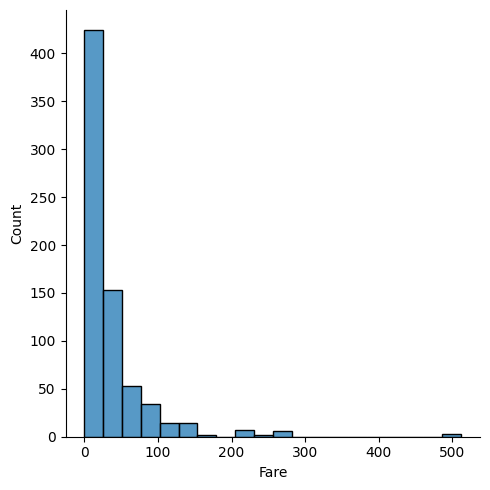

In [16]:
sns.displot(df_clustering.Fare, bins=20)

## Transform the feature

In [17]:
enc = sklearn.preprocessing.PowerTransformer()
enc.fit_transform(df_clustering[['Fare']])[:20]

array([[-0.99765031],
       [ 1.28775742],
       [-0.90107255],
       [ 1.02427568],
       [-0.88411158],
       [ 1.00273178],
       [ 0.13202717],
       [-0.53475875],
       [ 0.48661962],
       [-0.10705645],
       [ 0.36394683],
       [-0.88411158],
       [ 0.52494282],
       [-0.91080102],
       [-0.15160295],
       [ 0.45530075],
       [-0.029469  ],
       [ 0.34315814],
       [-0.36978947],
       [-0.88691511]])

## Add the transformed feature into the *df_encoded* dataframe

In [18]:
df_encoded['Fare'] = sklearn.preprocessing.PowerTransformer().fit_transform(df_clustering[['Fare']])

## Plot histogram of the transformer feature
* üîé What has changed?

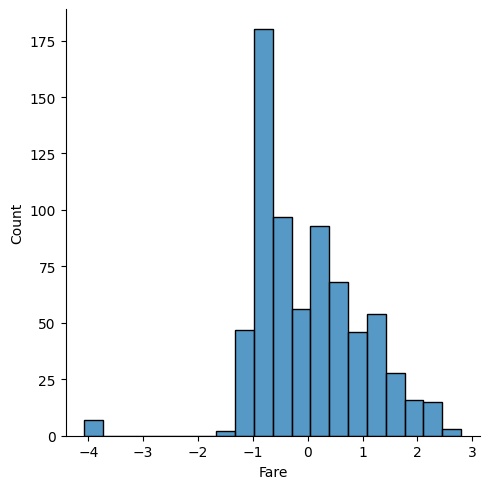

In [19]:
sns.displot(df_encoded.Fare, bins=20)

## Scale the *Age* using MinMax scaler
* `sklearn.preprocessing.minmax_scale`

In [20]:
df_encoded['Age'] = sklearn.preprocessing.minmax_scale(df_clustering['Age'])

## Join the *df_encoded* and *['Survived', 'Pclass', 'SibSp', 'Parch']* features

In [21]:
df_encoded = df_encoded.join(df_clustering[['Survived', 'Pclass', 'SibSp', 'Parch']])

# We finally got to the clustering part üòÆ‚Äçüí®

![meme02](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_04_meme_02.jpg?raw=true)

## There are methods how to identify probable number of clusters in the data
* It is always a rough estimate

## üí° We can use **Elbow method** to identify potentially ideal number of clusters in our data in **KMeans** algorithm.

There are two basic methods for evaluation of clusters quality:
1. SSE - Sum of squared distances of samples to their closest cluster center, this one is specific for **KMeans** algorithm.
    * You can find it as **inertia_** attribute of KMeans sklearn object.
2. Silhouette Coefficient - calculated using the mean intra-cluster distance and the mean nearest-cluster distance

## üí° We ussually want to find number of clusters with low SSE and high Silhoutte coef.
- Take a look at [this](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) and [this](https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a) for more details

## Try different number of clusters from range <2, 10> for KMeans algorithm, save both evaluation criteria and plot dependency of criteria to number of clusters.
* We will use `sklearn.cluster.KMeans` class
* The most important parameter is the *n_clusters*
    * What is the *random_state* parameter?

In [22]:
X = df_encoded.values

In [23]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k, random_state=13).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')

In [24]:
df_clustering_scores

sse  silhouette
k                          
2   2051.762020    0.334082
3   1580.250928    0.364262
4   1360.796955    0.379880
5   1220.122090    0.267616
6   1138.545101    0.248358
7   1043.928558    0.277009
8   1000.976087    0.286154
9    932.731933    0.294794
10   883.114822    0.296287

## Plot the SSE and Silhouette score

<Axes: xlabel='k', ylabel='sse'>

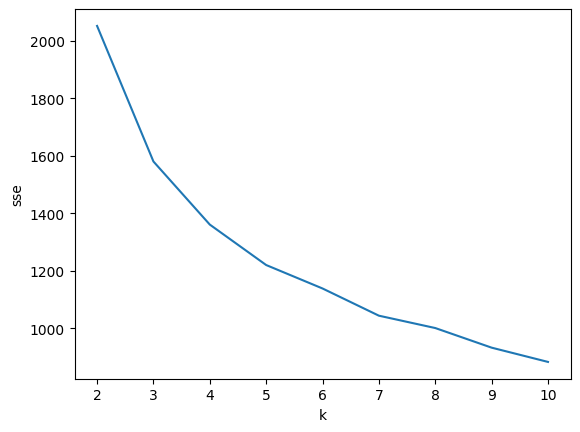

In [25]:
sns.lineplot(data = df_clustering_scores, y='sse', x='k')

<Axes: xlabel='k', ylabel='silhouette'>

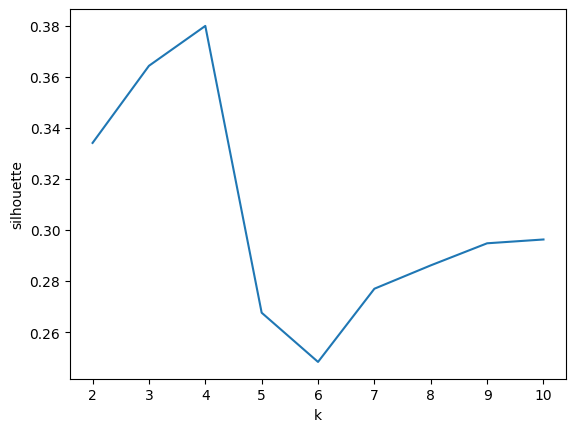

In [26]:
sns.lineplot(data = df_clustering_scores, y='silhouette', x='k')

# üîé What is the probable number of clusters in the data?

## Let's try to analyze the data assigned into **4** clusters

In [28]:
clustering = sklearn.cluster.KMeans(n_clusters=4, random_state=13).fit(X)
clustering.fit(X)

KMeans(n_clusters=4, random_state=13)

## How big are our clusters? How many 0, 1, .. are in *labels_* property?

In [29]:
pd.Series(clustering.labels_).value_counts()

0    396
1    229
2     44
3     43
Name: count, dtype: int64

# üìí Explore clusters
* Try to use cluster information for exploration analysis of our data
    * Create new feature *cluster_id* with the *labels_* property data

In [30]:
df_clustering['cluster_id'] = clustering.labels_
df_clustering.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
PassengerId                                                                   
1                   0       3    male  22.0      1      0   7.2500        S   
2                   1       1  female  38.0      1      0  71.2833        C   
3                   1       3  female  26.0      0      0   7.9250        S   
4                   1       1  female  35.0      1      0  53.1000        S   
5                   0       3    male  35.0      0      0   8.0500        S   

             cluster_id  
PassengerId              
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

## üöÄ Hint: You can use *sns.countplot* as a visual *.value_counts()* method

<Axes: xlabel='cluster_id', ylabel='count'>

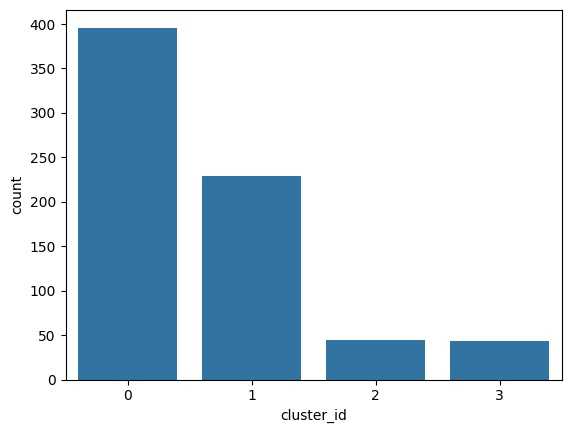

In [31]:
sns.countplot(data=df_clustering, x='cluster_id')

## üéØ Create plots showing values of different attributes based on cluster group and describe them
* Let's follow the four example questions about the data to solve the task

### ‚ùì Questions ‚ùì
1. Is **Fare** different for points in different clusters?
    * üí° Use *plt.yscale('log')* to take care of the outlier/variance effect
2. Is **Age** different for point in different clusters?
3. Does rate of suvival differ in clusters?
    * *Survived*
4. Does number of passanger of each class differ in clusters?
    * *Pclass*

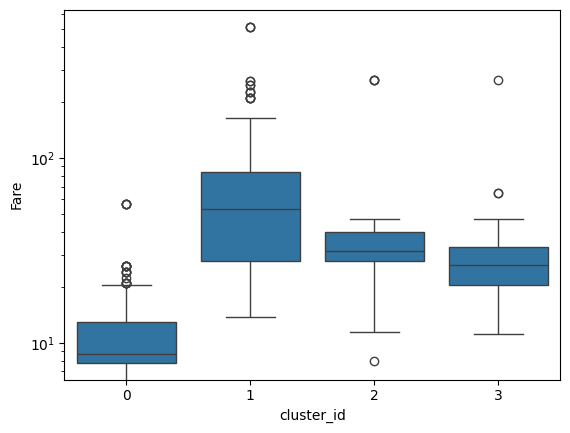

In [32]:
sns.boxplot(data=df_clustering, x='cluster_id', y='Fare')
plt.yscale('log')

<Axes: xlabel='cluster_id', ylabel='Age'>

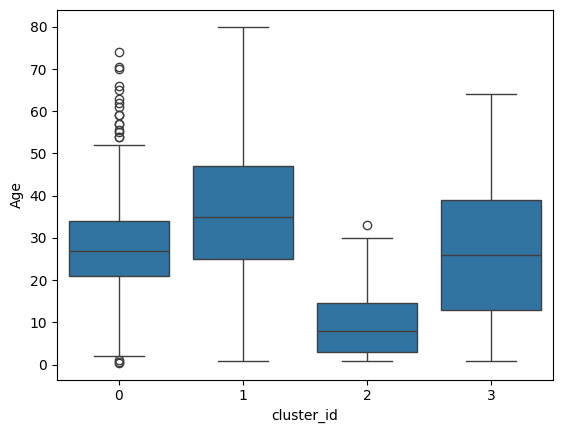

In [33]:
sns.boxplot(data=df_clustering, x='cluster_id', y='Age')

<Axes: xlabel='cluster_id', ylabel='count'>

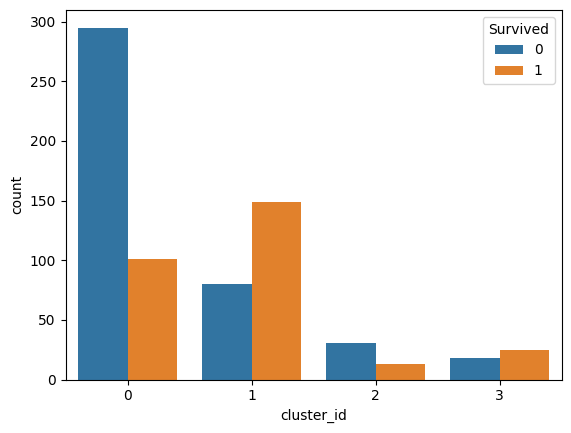

In [34]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

<Axes: xlabel='cluster_id', ylabel='count'>

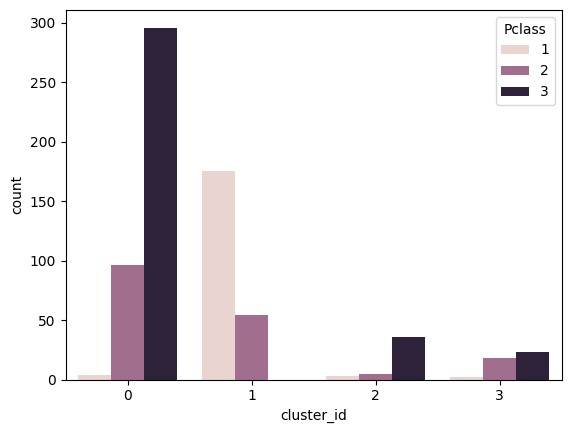

In [35]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass')

# üìù Write a textual description of the four clusters

### Cluster 1 - ...
### Cluster 2 - ...
### Cluster 3 - ...
### Cluster 4 - ...

# Is our data represented in the best way?

* **Clustering methods depends on calculation of distance metric among data points in our data matrix.**
* Therefore it is necessary to preproces our data matrix **X** in a best way possible to achive equal distance for every dataset feature.
    * After such transformation we can presume, that difference in *Age* has same impact as the difference as in the *Fare* feature.
* **Generally, it is very hard to create perfect tranformation for our real dataset.**

## Use StandardScaler transformation for our data **X**

In [38]:
col_names = ['Fare', 'Age', 'SibSp', 'Parch']
enc = sklearn.preprocessing.StandardScaler()
X_stand = pd.DataFrame(enc.fit_transform(df_clustering.loc[:, col_names]), columns = col_names, index=df_clustering.index)
X_stand = pd.concat([X_stand, df_encoded.loc[:, ['Sex', 'C', 'Q', 'S']], df_clustering.Survived], axis=1)

In [39]:
X_stand

Fare       Age     SibSp     Parch  Sex      C      Q      S  \
PassengerId                                                                     
1           -0.516380 -0.527669  0.522511 -0.506787  1.0  False  False   True   
2            0.694046  0.577094  0.522511 -0.506787  0.0   True  False  False   
3           -0.503620 -0.251478 -0.552714 -0.506787  0.0  False  False   True   
4            0.350326  0.369951  0.522511 -0.506787  0.0  False  False   True   
5           -0.501257  0.369951 -0.552714 -0.506787  1.0  False  False   True   
...               ...       ...       ...       ...  ...    ...    ...    ...   
886         -0.102875  0.646142 -0.552714  5.350885  0.0  False   True  False   
887         -0.407687 -0.182430 -0.552714 -0.506787  1.0  False  False   True   
888         -0.086335 -0.734812 -0.552714 -0.506787  0.0  False  False   True   
890         -0.086335 -0.251478 -0.552714 -0.506787  1.0   True  False  False   
891         -0.506928  0.162808 -0.552714 -0.506787  1.0  False   True  False   

             Survived  
PassengerId            
1                   0  
2                   1  
3                   1  
4                   1  
5                   0  
...               ...  
886                 0  
887                 0  
888                 1  
890                 1  
891                 0  

[712 rows x 9 columns]

In [40]:
X_stand.describe()

Fare           Age         SibSp         Parch         Sex  \
count  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02  712.000000   
mean  -6.736185e-17  2.943962e-16 -1.496930e-17  1.496930e-17    0.636236   
std    1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00    0.481420   
min   -6.534272e-01 -2.017717e+00 -5.527137e-01 -5.067874e-01    0.000000   
25%   -5.012575e-01 -6.657639e-01 -5.527137e-01 -5.067874e-01    0.000000   
50%   -3.576726e-01 -1.133826e-01 -5.527137e-01 -5.067874e-01    1.000000   
75%   -2.962586e-02  5.770939e-01  5.225108e-01  6.647471e-01    1.000000   
max    9.031168e+00  3.477095e+00  4.823409e+00  6.522419e+00    1.000000   

         Survived  
count  712.000000  
mean     0.404494  
std      0.491139  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

# ‚úÖ Task (2p)
1. Use **KMeans** to differently preprocessed data matrix **X_stand**
2. Detect "ideal" number of clusters using Elbow method
3. Explore detected clusters and **describe** them to the Markdown cell
    * **Describe the insight you got from the plots with a few sentences in a Markdown cell below the plot**
        * ‚ùå Plot interpretation figured in real-time during task check is not allowed! ‚ùå